This UFC project takes fight data from 1993 to 2023 and utilizes various machine learning models to predict the probabilities of future fights.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [377]:
df = pd.read_csv('raw_total_fight_data.csv', sep = ';') # ; For fixing formatting

In [378]:
df.head()

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR.,B_SIG_STR.,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR.,B_TOTAL_STR.,R_TD,B_TD,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,R_REV,B_REV,R_CTRL,B_CTRL,R_HEAD,B_HEAD,R_BODY,B_BODY,R_LEG,B_LEG,R_DISTANCE,B_DISTANCE,R_CLINCH,B_CLINCH,R_GROUND,B_GROUND,win_by,last_round,last_round_time,Format,Referee,date,location,Fight_type,Winner
0,Michelle Waterson-Gomez,Luana Pinheiro,0,0,61 of 188,44 of 122,32%,36%,70 of 199,48 of 132,1 of 2,0 of 5,50%,0%,0,0,0,0,1:01,1:25,18 of 114,16 of 79,16 of 34,15 of 21,27 of 40,13 of 22,53 of 178,38 of 109,8 of 10,6 of 13,0 of 0,0 of 0,Decision - Split,3,5:00,3 Rnd (5-5-5),Larry Folsom,"April 08, 2023","Miami, Florida, USA",Women's Strawweight Bout,Luana Pinheiro
1,Gilbert Burns,Jorge Masvidal,0,0,42 of 99,39 of 91,42%,42%,72 of 135,77 of 130,4 of 6,0 of 0,66%,---,0,0,0,0,5:41,0:05,34 of 84,14 of 61,3 of 7,8 of 11,5 of 8,17 of 19,37 of 90,38 of 90,0 of 0,1 of 1,5 of 9,0 of 0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Marc Goddard,"April 08, 2023","Miami, Florida, USA",Welterweight Bout,Gilbert Burns
2,Rob Font,Adrian Yanez,1,0,33 of 75,25 of 54,44%,46%,33 of 75,25 of 54,0 of 1,0 of 0,0%,---,0,0,0,0,0:04,0:00,30 of 69,21 of 49,2 of 5,1 of 2,1 of 1,3 of 3,27 of 66,25 of 51,1 of 2,0 of 3,5 of 7,0 of 0,KO/TKO,1,2:57,3 Rnd (5-5-5),Keith Peterson,"April 08, 2023","Miami, Florida, USA",Bantamweight Bout,Rob Font
3,Gerald Meerschaert,Joe Pyfer,0,0,10 of 21,14 of 24,47%,58%,10 of 21,14 of 24,0 of 0,0 of 0,---,---,0,0,0,0,0:00,0:16,1 of 12,6 of 16,2 of 2,8 of 8,7 of 7,0 of 0,10 of 21,6 of 11,0 of 0,0 of 0,0 of 0,8 of 13,KO/TKO,1,3:15,3 Rnd (5-5-5),Marc Goddard,"April 08, 2023","Miami, Florida, USA",Middleweight Bout,Joe Pyfer
4,Chris Curtis,Kelvin Gastelum,0,0,70 of 201,83 of 188,34%,44%,80 of 216,88 of 195,0 of 0,0 of 3,---,0%,0,0,0,0,0:01,1:21,44 of 164,63 of 161,21 of 30,5 of 8,5 of 7,15 of 19,63 of 193,76 of 172,7 of 8,3 of 6,0 of 0,4 of 10,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Marc Goddard,"April 08, 2023","Miami, Florida, USA",Middleweight Bout,Kelvin Gastelum


In [379]:
df.shape

(7051, 41)

# **Data Cleaning**

We drop columns that are not relevant to our models and rename abreviations to its full definition

In [380]:
to_drop = ['R_REV','B_REV','R_HEAD', 'B_HEAD', 'R_BODY', 'B_BODY', 'R_LEG', 'B_LEG', 'R_DISTANCE', 'B_DISTANCE', 'R_CLINCH', 'B_CLINCH']
df = df.drop(to_drop, axis=1)

In [381]:
to_drop2 = ['Referee','location']
df = df.drop(to_drop2, axis=1)

In [382]:
df['Format'] = df['Format'].str.extract(r'(\d+)')
df = df.rename(columns={'Format': 'No_of_rounds'})
df = df.rename(columns={'R_KD': 'R_Knockdown'})
df = df.rename(columns={'B_KD': 'B_Knockdown'})

In [383]:
df = df.rename(columns={'R_SIG_STR.': 'R_Significant_Strikes'})
df = df.rename(columns={'B_SIG_STR.': 'B_Significant_Strikes'})

df = df.rename(columns={'R_SIG_STR_pct': 'R_Significant_Strike_Percent'})
df = df.rename(columns={'B_SIG_STR_pct': 'B_Significant_Strike_Percent'})

In [384]:
df = df.rename(columns={'R_TOTAL_STR.': 'R_Total_Strikes'})
df = df.rename(columns={'B_TOTAL_STR.': 'B_Total_Strikes'})

In [385]:
df = df.rename(columns={'R_TD': 'R_Takedowns'})
df = df.rename(columns={'B_TD': 'B_Takedowns'})

In [386]:
df = df.rename(columns={'R_TD_pct': 'R_Takedown_Percent'})
df = df.rename(columns={'B_TD_pct': 'B_Takedown_Percent'})

In [387]:
df = df.rename(columns={'R_SUB_ATT': 'R_Submission_Attempt'})
df = df.rename(columns={'B_SUB_ATT': 'B_Submission_Attempt'})

In [388]:
df = df.rename(columns={'R_CTRL': 'R_Ground_Control'})
df = df.rename(columns={'B_CTRL': 'B_Ground_Control'})

In [389]:
df = df.rename(columns={'R_GROUND': 'R_Ground_Strikes'})
df = df.rename(columns={'B_GROUND': 'B_Ground_Strikes'})

In [390]:
df.head()

,R_fighter,B_fighter,R_Knockdown,B_Knockdown,R_Significant_Strikes,B_Significant_Strikes,R_Significant_Strike_Percent,B_Significant_Strike_Percent,R_Total_Strikes,B_Total_Strikes,R_Takedowns,B_Takedowns,R_Takedown_Percent,B_Takedown_Percent,R_Submission_Attempt,B_Submission_Attempt,R_Ground_Control,B_Ground_Control,R_Ground_Strikes,B_Ground_Strikes,win_by,last_round,last_round_time,No_of_rounds,date,Fight_type,Winner
0,Michelle Waterson-Gomez,Luana Pinheiro,0,0,61 of 188,44 of 122,32%,36%,70 of 199,48 of 132,1 of 2,0 of 5,50%,0%,0,0,1:01,1:25,0 of 0,0 of 0,Decision - Split,3,5:00,3,"April 08, 2023",Women's Strawweight Bout,Luana Pinheiro
1,Gilbert Burns,Jorge Masvidal,0,0,42 of 99,39 of 91,42%,42%,72 of 135,77 of 130,4 of 6,0 of 0,66%,---,0,0,5:41,0:05,5 of 9,0 of 0,Decision - Unanimous,3,5:00,3,"April 08, 2023",Welterweight Bout,Gilbert Burns
2,Rob Font,Adrian Yanez,1,0,33 of 75,25 of 54,44%,46%,33 of 75,25 of 54,0 of 1,0 of 0,0%,---,0,0,0:04,0:00,5 of 7,0 of 0,KO/TKO,1,2:57,3,"April 08, 2023",Bantamweight Bout,Rob Font
3,Gerald Meerschaert,Joe Pyfer,0,0,10 of 21,14 of 24,47%,58%,10 of 21,14 of 24,0 of 0,0 of 0,---,---,0,0,0:00,0:16,0 of 0,8 of 13,KO/TKO,1,3:15,3,"April 08, 2023",Middleweight Bout,Joe Pyfer
4,Chris Curtis,Kelvin Gastelum,0,0,70 of 201,83 of 188,34%,44%,80 of 216,88 of 195,0 of 0,0 of 3,---,0%,0,0,0:01,1:21,0 of 0,4 of 10,Decision - Unanimous,3,5:00,3,"April 08, 2023",Middleweight Bout,Kelvin Gastelum


Remove 'of'

In [391]:
df[['R_Significant_Strikes_Landed', 'R_Significant_Strikes_Attempted']] = df['R_Significant_Strikes'].str.split(' of ', expand=True)
df[['B_Significant_Strikes_Landed', 'B_Significant_Strikes_Attempted']] = df['B_Significant_Strikes'].str.split(' of ', expand=True)

to_drop3 = ['R_Significant_Strikes','B_Significant_Strikes']
df = df.drop(to_drop3, axis=1)


In [392]:
df[['R_Total_Strikes_Landed', 'R_Total_Strikes_Attempted']] = df['R_Total_Strikes'].str.split(' of ', expand=True)
df[['B_Total_Strikes_Landed', 'B_Total_Strikes_Attempted']] = df['B_Total_Strikes'].str.split(' of ', expand=True)

to_drop3 = ['R_Total_Strikes','B_Total_Strikes']
df = df.drop(to_drop3, axis=1)

In [393]:
df[['R_Takedowns_Landed', 'R_Takedowns_Attempted']] = df['R_Takedowns'].str.split(' of ', expand=True)
df[['B_Takedowns_Landed', 'B_Takedowns_Attempted']] = df['B_Takedowns'].str.split(' of ', expand=True)

to_drop3 = ['R_Takedowns','B_Takedowns']
df = df.drop(to_drop3, axis=1)

In [394]:
df[['R_Ground_Strikes_Landed', 'R_Ground_Strikes_Attempted']] = df['R_Ground_Strikes'].str.split(' of ', expand=True)
df[['B_Ground_Strikes_Landed', 'B_Ground_Strikes_Attempted']] = df['B_Ground_Strikes'].str.split(' of ', expand=True)

to_drop3 = ['R_Ground_Strikes','B_Ground_Strikes']
df = df.drop(to_drop3, axis=1)

Remove the '%' symbol from the values in the column

In [395]:
df['R_Significant_Strike_Percent'] = df['R_Significant_Strike_Percent'].str.replace('%', '')
df['B_Significant_Strike_Percent'] = df['B_Significant_Strike_Percent'].str.replace('%', '')
df['R_Takedown_Percent'] = df['R_Takedown_Percent'].str.replace('%', '')
df['B_Takedown_Percent'] = df['B_Takedown_Percent'].str.replace('%', '')

In [396]:
df['R_Significant_Strike_Percent'] = df['R_Significant_Strike_Percent'].str.replace('---', '0')
df['B_Significant_Strike_Percent'] = df['B_Significant_Strike_Percent'].str.replace('---', '0')
df['R_Takedown_Percent'] = df['R_Takedown_Percent'].str.replace('---', '0')
df['B_Takedown_Percent'] = df['B_Takedown_Percent'].str.replace('---', '0')

In [397]:
df.shape

(7051, 35)

In [398]:
print(df['date'].dtype)

object


In [399]:
df['date'] = pd.to_datetime(df['date'], format="%B %d, %Y").dt.strftime("%Y-%m-%d")

Before April 2001, there were no rules in UFC with different rules to the sport, hence we will only consider fights after this date.

In [400]:
limit_date = '2001-04-01'
df = df[(df['date'] > limit_date)]
print(df.shape)

(6797, 35)


In [401]:
df.head()

,R_fighter,B_fighter,R_Knockdown,B_Knockdown,R_Significant_Strike_Percent,B_Significant_Strike_Percent,R_Takedown_Percent,B_Takedown_Percent,R_Submission_Attempt,B_Submission_Attempt,R_Ground_Control,B_Ground_Control,win_by,last_round,last_round_time,No_of_rounds,date,Fight_type,Winner,R_Significant_Strikes_Landed,R_Significant_Strikes_Attempted,B_Significant_Strikes_Landed,B_Significant_Strikes_Attempted,R_Total_Strikes_Landed,R_Total_Strikes_Attempted,B_Total_Strikes_Landed,B_Total_Strikes_Attempted,R_Takedowns_Landed,R_Takedowns_Attempted,B_Takedowns_Landed,B_Takedowns_Attempted,R_Ground_Strikes_Landed,R_Ground_Strikes_Attempted,B_Ground_Strikes_Landed,B_Ground_Strikes_Attempted
0,Michelle Waterson-Gomez,Luana Pinheiro,0,0,32,36,50,0,0,0,1:01,1:25,Decision - Split,3,5:00,3,2023-04-08,Women's Strawweight Bout,Luana Pinheiro,61,188,44,122,70,199,48,132,1,2,0,5,0,0,0,0
1,Gilbert Burns,Jorge Masvidal,0,0,42,42,66,0,0,0,5:41,0:05,Decision - Unanimous,3,5:00,3,2023-04-08,Welterweight Bout,Gilbert Burns,42,99,39,91,72,135,77,130,4,6,0,0,5,9,0,0
2,Rob Font,Adrian Yanez,1,0,44,46,0,0,0,0,0:04,0:00,KO/TKO,1,2:57,3,2023-04-08,Bantamweight Bout,Rob Font,33,75,25,54,33,75,25,54,0,1,0,0,5,7,0,0
3,Gerald Meerschaert,Joe Pyfer,0,0,47,58,0,0,0,0,0:00,0:16,KO/TKO,1,3:15,3,2023-04-08,Middleweight Bout,Joe Pyfer,10,21,14,24,10,21,14,24,0,0,0,0,0,0,8,13
4,Chris Curtis,Kelvin Gastelum,0,0,34,44,0,0,0,0,0:01,1:21,Decision - Unanimous,3,5:00,3,2023-04-08,Middleweight Bout,Kelvin Gastelum,70,201,83,188,80,216,88,195,0,0,0,3,0,0,4,10


In [402]:
print(df['win_by'].unique())

['Decision - Split' 'Decision - Unanimous' 'KO/TKO' 'Submission'
 'Decision - Majority' "TKO - Doctor's Stoppage" 'Overturned'
 'Could Not Continue' 'DQ' 'Other']


Removing NaN rows in Winner column.

In [403]:
df = df.dropna(subset=['Winner'])

In [404]:
print("Total NaN in dataframe :" , df.isna().sum().sum())
print("Total NaN in each column of the dataframe")
na = []
for index, col in enumerate(df):
    na.append((index, df[col].isna().sum())) 
na_sorted = na.copy()
na_sorted.sort(key = lambda x: x[1], reverse = True) 

for i in range(len(df.columns)):
    print(df.columns[na_sorted[i][0]],":", na_sorted[i][1], "NaN")

Total NaN in dataframe : 0
Total NaN in each column of the dataframe
R_fighter : 0 NaN
B_fighter : 0 NaN
R_Knockdown : 0 NaN
B_Knockdown : 0 NaN
R_Significant_Strike_Percent : 0 NaN
B_Significant_Strike_Percent : 0 NaN
R_Takedown_Percent : 0 NaN
B_Takedown_Percent : 0 NaN
R_Submission_Attempt : 0 NaN
B_Submission_Attempt : 0 NaN
R_Ground_Control : 0 NaN
B_Ground_Control : 0 NaN
win_by : 0 NaN
last_round : 0 NaN
last_round_time : 0 NaN
No_of_rounds : 0 NaN
date : 0 NaN
Fight_type : 0 NaN
Winner : 0 NaN
R_Significant_Strikes_Landed : 0 NaN
R_Significant_Strikes_Attempted : 0 NaN
B_Significant_Strikes_Landed : 0 NaN
B_Significant_Strikes_Attempted : 0 NaN
R_Total_Strikes_Landed : 0 NaN
R_Total_Strikes_Attempted : 0 NaN
B_Total_Strikes_Landed : 0 NaN
B_Total_Strikes_Attempted : 0 NaN
R_Takedowns_Landed : 0 NaN
R_Takedowns_Attempted : 0 NaN
B_Takedowns_Landed : 0 NaN
B_Takedowns_Attempted : 0 NaN
R_Ground_Strikes_Landed : 0 NaN
R_Ground_Strikes_Attempted : 0 NaN
B_Ground_Strikes_Landed : 0 

We have now finished cleaning the dataset by removing all NaN rows

# **Feature Engineering and EDA**

In [405]:
def calculate_total_duration(value):
    parts = value.split(':')
    minutes = int(parts[0])
    seconds = int(parts[1])
    total_seconds = minutes * 60 + seconds
    return total_seconds


df['last_round_time'] = df['last_round_time'].apply(calculate_total_duration)


In [406]:
df['time_fought'] = (df['last_round'] - 1) * 5 * 60 + df['last_round_time']

In [407]:
to_drop = ['last_round','last_round_time']
df = df.drop(to_drop, axis=1)

In [408]:
df.head()

,R_fighter,B_fighter,R_Knockdown,B_Knockdown,R_Significant_Strike_Percent,B_Significant_Strike_Percent,R_Takedown_Percent,B_Takedown_Percent,R_Submission_Attempt,B_Submission_Attempt,R_Ground_Control,B_Ground_Control,win_by,No_of_rounds,date,Fight_type,Winner,R_Significant_Strikes_Landed,R_Significant_Strikes_Attempted,B_Significant_Strikes_Landed,B_Significant_Strikes_Attempted,R_Total_Strikes_Landed,R_Total_Strikes_Attempted,B_Total_Strikes_Landed,B_Total_Strikes_Attempted,R_Takedowns_Landed,R_Takedowns_Attempted,B_Takedowns_Landed,B_Takedowns_Attempted,R_Ground_Strikes_Landed,R_Ground_Strikes_Attempted,B_Ground_Strikes_Landed,B_Ground_Strikes_Attempted,time_fought
0,Michelle Waterson-Gomez,Luana Pinheiro,0,0,32,36,50,0,0,0,1:01,1:25,Decision - Split,3,2023-04-08,Women's Strawweight Bout,Luana Pinheiro,61,188,44,122,70,199,48,132,1,2,0,5,0,0,0,0,900
1,Gilbert Burns,Jorge Masvidal,0,0,42,42,66,0,0,0,5:41,0:05,Decision - Unanimous,3,2023-04-08,Welterweight Bout,Gilbert Burns,42,99,39,91,72,135,77,130,4,6,0,0,5,9,0,0,900
2,Rob Font,Adrian Yanez,1,0,44,46,0,0,0,0,0:04,0:00,KO/TKO,3,2023-04-08,Bantamweight Bout,Rob Font,33,75,25,54,33,75,25,54,0,1,0,0,5,7,0,0,177
3,Gerald Meerschaert,Joe Pyfer,0,0,47,58,0,0,0,0,0:00,0:16,KO/TKO,3,2023-04-08,Middleweight Bout,Joe Pyfer,10,21,14,24,10,21,14,24,0,0,0,0,0,0,8,13,195
4,Chris Curtis,Kelvin Gastelum,0,0,34,44,0,0,0,0,0:01,1:21,Decision - Unanimous,3,2023-04-08,Middleweight Bout,Kelvin Gastelum,70,201,83,188,80,216,88,195,0,0,0,3,0,0,4,10,900


In [409]:
df_DQ = df[df['win_by'] == 'DQ']

df_DQ.head(2)

,R_fighter,B_fighter,R_Knockdown,B_Knockdown,R_Significant_Strike_Percent,B_Significant_Strike_Percent,R_Takedown_Percent,B_Takedown_Percent,R_Submission_Attempt,B_Submission_Attempt,R_Ground_Control,B_Ground_Control,win_by,No_of_rounds,date,Fight_type,Winner,R_Significant_Strikes_Landed,R_Significant_Strikes_Attempted,B_Significant_Strikes_Landed,B_Significant_Strikes_Attempted,R_Total_Strikes_Landed,R_Total_Strikes_Attempted,B_Total_Strikes_Landed,B_Total_Strikes_Attempted,R_Takedowns_Landed,R_Takedowns_Attempted,B_Takedowns_Landed,B_Takedowns_Attempted,R_Ground_Strikes_Landed,R_Ground_Strikes_Attempted,B_Ground_Strikes_Landed,B_Ground_Strikes_Attempted,time_fought
494,Dean Barry,Mike Jackson,1,0,40,48,0,0,0,0,0:15,0:09,DQ,3,2022-04-23,Welterweight Bout,Mike Jackson,36,90,18,37,39,93,18,37,0,0,0,1,2,4,0,0,232
985,Randa Markos,Luana Pinheiro,0,0,45,54,0,83,0,0,0:29,0:54,DQ,3,2021-05-01,Women's Strawweight Bout,Luana Pinheiro,18,40,29,53,28,51,35,61,0,0,5,6,1,1,2,8,256


In [410]:
 df = df.drop(df[df['win_by'] == 'DQ'].index)

In [411]:
df_DQ = df[df['win_by'] == 'DQ']
df_DQ.head(2)

,R_fighter,B_fighter,R_Knockdown,B_Knockdown,R_Significant_Strike_Percent,B_Significant_Strike_Percent,R_Takedown_Percent,B_Takedown_Percent,R_Submission_Attempt,B_Submission_Attempt,R_Ground_Control,B_Ground_Control,win_by,No_of_rounds,date,Fight_type,Winner,R_Significant_Strikes_Landed,R_Significant_Strikes_Attempted,B_Significant_Strikes_Landed,B_Significant_Strikes_Attempted,R_Total_Strikes_Landed,R_Total_Strikes_Attempted,B_Total_Strikes_Landed,B_Total_Strikes_Attempted,R_Takedowns_Landed,R_Takedowns_Attempted,B_Takedowns_Landed,B_Takedowns_Attempted,R_Ground_Strikes_Landed,R_Ground_Strikes_Attempted,B_Ground_Strikes_Landed,B_Ground_Strikes_Attempted,time_fought


Creating two separate dataframes for R and B, and will combine them vertically afterwards.

In [412]:
R_subset = ['R_fighter','R_Knockdown','R_Significant_Strike_Percent','R_Takedown_Percent', 'R_Submission_Attempt','R_Ground_Control', 'win_by', 'No_of_rounds', 'date', 'Fight_type',
            'R_Significant_Strikes_Landed', 'R_Significant_Strikes_Attempted', 'R_Total_Strikes_Landed', 'R_Total_Strikes_Attempted', 'R_Takedowns_Landed', 'R_Takedowns_Attempted', 
            'R_Ground_Strikes_Landed', 'time_fought','Winner']
R_df = df[R_subset]
R_df = R_df.rename(columns=lambda x: x.replace('R_', ''))

R_df['Winner'] = np.where(R_df['Winner'] == R_df['fighter'], 1, 0)

R_df.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,date,Fight_type,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Winner
0,Michelle Waterson-Gomez,0,32,50,0,1:01,Decision - Split,3,2023-04-08,Women's Strawweight Bout,61,188,70,199,1,2,0,900,0
1,Gilbert Burns,0,42,66,0,5:41,Decision - Unanimous,3,2023-04-08,Welterweight Bout,42,99,72,135,4,6,5,900,1
2,Rob Font,1,44,0,0,0:04,KO/TKO,3,2023-04-08,Bantamweight Bout,33,75,33,75,0,1,5,177,1
3,Gerald Meerschaert,0,47,0,0,0:00,KO/TKO,3,2023-04-08,Middleweight Bout,10,21,10,21,0,0,0,195,0
4,Chris Curtis,0,34,0,0,0:01,Decision - Unanimous,3,2023-04-08,Middleweight Bout,70,201,80,216,0,0,0,900,0


In [413]:
B_subset = ['B_fighter', 'B_Knockdown', 'B_Significant_Strike_Percent', 'B_Takedown_Percent', 'B_Submission_Attempt',
            'B_Ground_Control', 'win_by', 'No_of_rounds', 'date', 'Fight_type', 'B_Significant_Strikes_Landed',
            'B_Significant_Strikes_Attempted', 'B_Total_Strikes_Landed', 'B_Total_Strikes_Attempted', 
            'B_Takedowns_Landed', 'B_Takedowns_Attempted', 'B_Ground_Strikes_Landed', 'time_fought', 'Winner']
B_df = df[B_subset]
B_df = B_df.rename(columns=lambda x: x.replace('B_', ''))
B_df['Winner'] = np.where(B_df['Winner'] == B_df['fighter'], 1, 0)


B_df.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,date,Fight_type,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Winner
0,Luana Pinheiro,0,36,0,0,1:25,Decision - Split,3,2023-04-08,Women's Strawweight Bout,44,122,48,132,0,5,0,900,1
1,Jorge Masvidal,0,42,0,0,0:05,Decision - Unanimous,3,2023-04-08,Welterweight Bout,39,91,77,130,0,0,0,900,0
2,Adrian Yanez,0,46,0,0,0:00,KO/TKO,3,2023-04-08,Bantamweight Bout,25,54,25,54,0,0,0,177,0
3,Joe Pyfer,0,58,0,0,0:16,KO/TKO,3,2023-04-08,Middleweight Bout,14,24,14,24,0,0,8,195,1
4,Kelvin Gastelum,0,44,0,0,1:21,Decision - Unanimous,3,2023-04-08,Middleweight Bout,83,188,88,195,0,3,4,900,1


In [414]:
new_df = pd.concat([R_df, B_df])

# sort the combined dataframe by date
ufc = new_df.sort_values(by='date', ascending=False)
# reset the index
ufc = ufc.reset_index(drop=True)


In [415]:
ufc['Ground_Control'] = ufc['Ground_Control'].apply(calculate_total_duration)

In [416]:
ufc.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,date,Fight_type,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Winner
0,Michelle Waterson-Gomez,0,32,50,0,61,Decision - Split,3,2023-04-08,Women's Strawweight Bout,61,188,70,199,1,2,0,900,0
1,Gilbert Burns,0,42,66,0,341,Decision - Unanimous,3,2023-04-08,Welterweight Bout,42,99,72,135,4,6,5,900,1
2,Steve Garcia,1,42,0,0,15,KO/TKO,3,2023-04-08,Featherweight Bout,17,40,50,77,0,0,4,336,1
3,Sam Hughes,0,44,100,0,422,Decision - Unanimous,3,2023-04-08,Women's Strawweight Bout,46,104,107,176,1,1,21,900,1
4,Loopy Godinez,0,48,0,0,1,Decision - Split,3,2023-04-08,Women's Strawweight Bout,87,180,93,188,0,2,0,900,1


In [417]:
ufc['win_by'].unique()

array(['Decision - Split', 'Decision - Unanimous', 'KO/TKO', 'Submission',
       'Decision - Majority', "TKO - Doctor's Stoppage"], dtype=object)

To make 'win_by' column to numerical, I am assigning them numerical values based on how dominant their victory was. 

* 10 <- KO/TKO, Submission Victory 
* 9 <- Decision - Unanimous 
* 8 <- Decision - Majority 
* 7 <- Decision - Split


In [418]:
mapping = {
    'KO/TKO': 10,
    'Submission': 9,
    "TKO - Doctor's Stoppage": 9,
    'Decision - Unanimous': 9,
    'Decision - Majority': 8,
    'Decision - Split': 7
}

ufc['win_by'] = ufc['win_by'].replace(mapping)

In [419]:
ufc.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,date,Fight_type,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Winner
0,Michelle Waterson-Gomez,0,32,50,0,61,7,3,2023-04-08,Women's Strawweight Bout,61,188,70,199,1,2,0,900,0
1,Gilbert Burns,0,42,66,0,341,9,3,2023-04-08,Welterweight Bout,42,99,72,135,4,6,5,900,1
2,Steve Garcia,1,42,0,0,15,10,3,2023-04-08,Featherweight Bout,17,40,50,77,0,0,4,336,1
3,Sam Hughes,0,44,100,0,422,9,3,2023-04-08,Women's Strawweight Bout,46,104,107,176,1,1,21,900,1
4,Loopy Godinez,0,48,0,0,1,7,3,2023-04-08,Women's Strawweight Bout,87,180,93,188,0,2,0,900,1


In this section, I am cleaning the weight division column.


In [420]:
ufc['Fight_type'].unique()

array(["Women's Strawweight Bout", 'Welterweight Bout',
       'Featherweight Bout', 'Catch Weight Bout', 'Bantamweight Bout',
       'UFC Middleweight Title Bout', 'Middleweight Bout',
       "Women's Flyweight Bout", "Women's Bantamweight Bout",
       'Flyweight Bout', 'UFC Welterweight Title Bout',
       'Lightweight Bout', 'Heavyweight Bout', 'Light Heavyweight Bout',
       'UFC Heavyweight Title Bout', "UFC Women's Flyweight Title Bout",
       'UFC Interim Featherweight Title Bout',
       'UFC Lightweight Title Bout', 'UFC Flyweight Title Bout',
       "Women's Featherweight Bout", 'UFC Light Heavyweight Title Bout',
       "UFC Women's Strawweight Title Bout",
       'UFC Bantamweight Title Bout', 'UFC Interim Flyweight Title Bout',
       "UFC Women's Bantamweight Title Bout",
       'UFC Featherweight Title Bout',
       'UFC Interim Bantamweight Title Bout',
       'UFC Interim Heavyweight Title Bout',
       "UFC Women's Featherweight Title Bout",
       'UFC Interim Lig

In [421]:
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Bout', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Title', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Tournament', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Ultimate Fighter', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('UFC', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Interim', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Brazil', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('America', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('China', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('TUF', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Australia', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Nations', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Canada', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('vs.', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('UK', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace('Latin', '')
ufc['Fight_type'] = ufc['Fight_type'].str.replace("Women's", 'W')

In [422]:
ufc['Fight_type'] = ufc['Fight_type'].apply(lambda x: re.sub(r'\d+', ' ', x))


In [423]:
ufc['Fight_type'] = ufc['Fight_type'].str.strip()

In [424]:
ufc.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,date,Fight_type,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Winner
0,Michelle Waterson-Gomez,0,32,50,0,61,7,3,2023-04-08,W Strawweight,61,188,70,199,1,2,0,900,0
1,Gilbert Burns,0,42,66,0,341,9,3,2023-04-08,Welterweight,42,99,72,135,4,6,5,900,1
2,Steve Garcia,1,42,0,0,15,10,3,2023-04-08,Featherweight,17,40,50,77,0,0,4,336,1
3,Sam Hughes,0,44,100,0,422,9,3,2023-04-08,W Strawweight,46,104,107,176,1,1,21,900,1
4,Loopy Godinez,0,48,0,0,1,7,3,2023-04-08,W Strawweight,87,180,93,188,0,2,0,900,1


In [425]:
column_dtypes = ufc.dtypes
print(column_dtypes)

fighter                          object
Knockdown                         int64
Significant_Strike_Percent       object
Takedown_Percent                 object
Submission_Attempt                int64
Ground_Control                    int64
win_by                           object
No_of_rounds                     object
date                             object
Fight_type                       object
Significant_Strikes_Landed       object
Significant_Strikes_Attempted    object
Total_Strikes_Landed             object
Total_Strikes_Attempted          object
Takedowns_Landed                 object
Takedowns_Attempted              object
Ground_Strikes_Landed            object
time_fought                       int64
Winner                            int32
dtype: object


In [426]:
columns_to_convert = ['Significant_Strike_Percent', 'Takedown_Percent', 'win_by',
                     'No_of_rounds','Significant_Strikes_Landed','Significant_Strikes_Attempted',
                     'Total_Strikes_Landed','Total_Strikes_Attempted','Takedowns_Landed',
                      'Takedowns_Attempted','Ground_Strikes_Landed']

ufc[columns_to_convert] = ufc[columns_to_convert].astype('int64')


<Axes: >

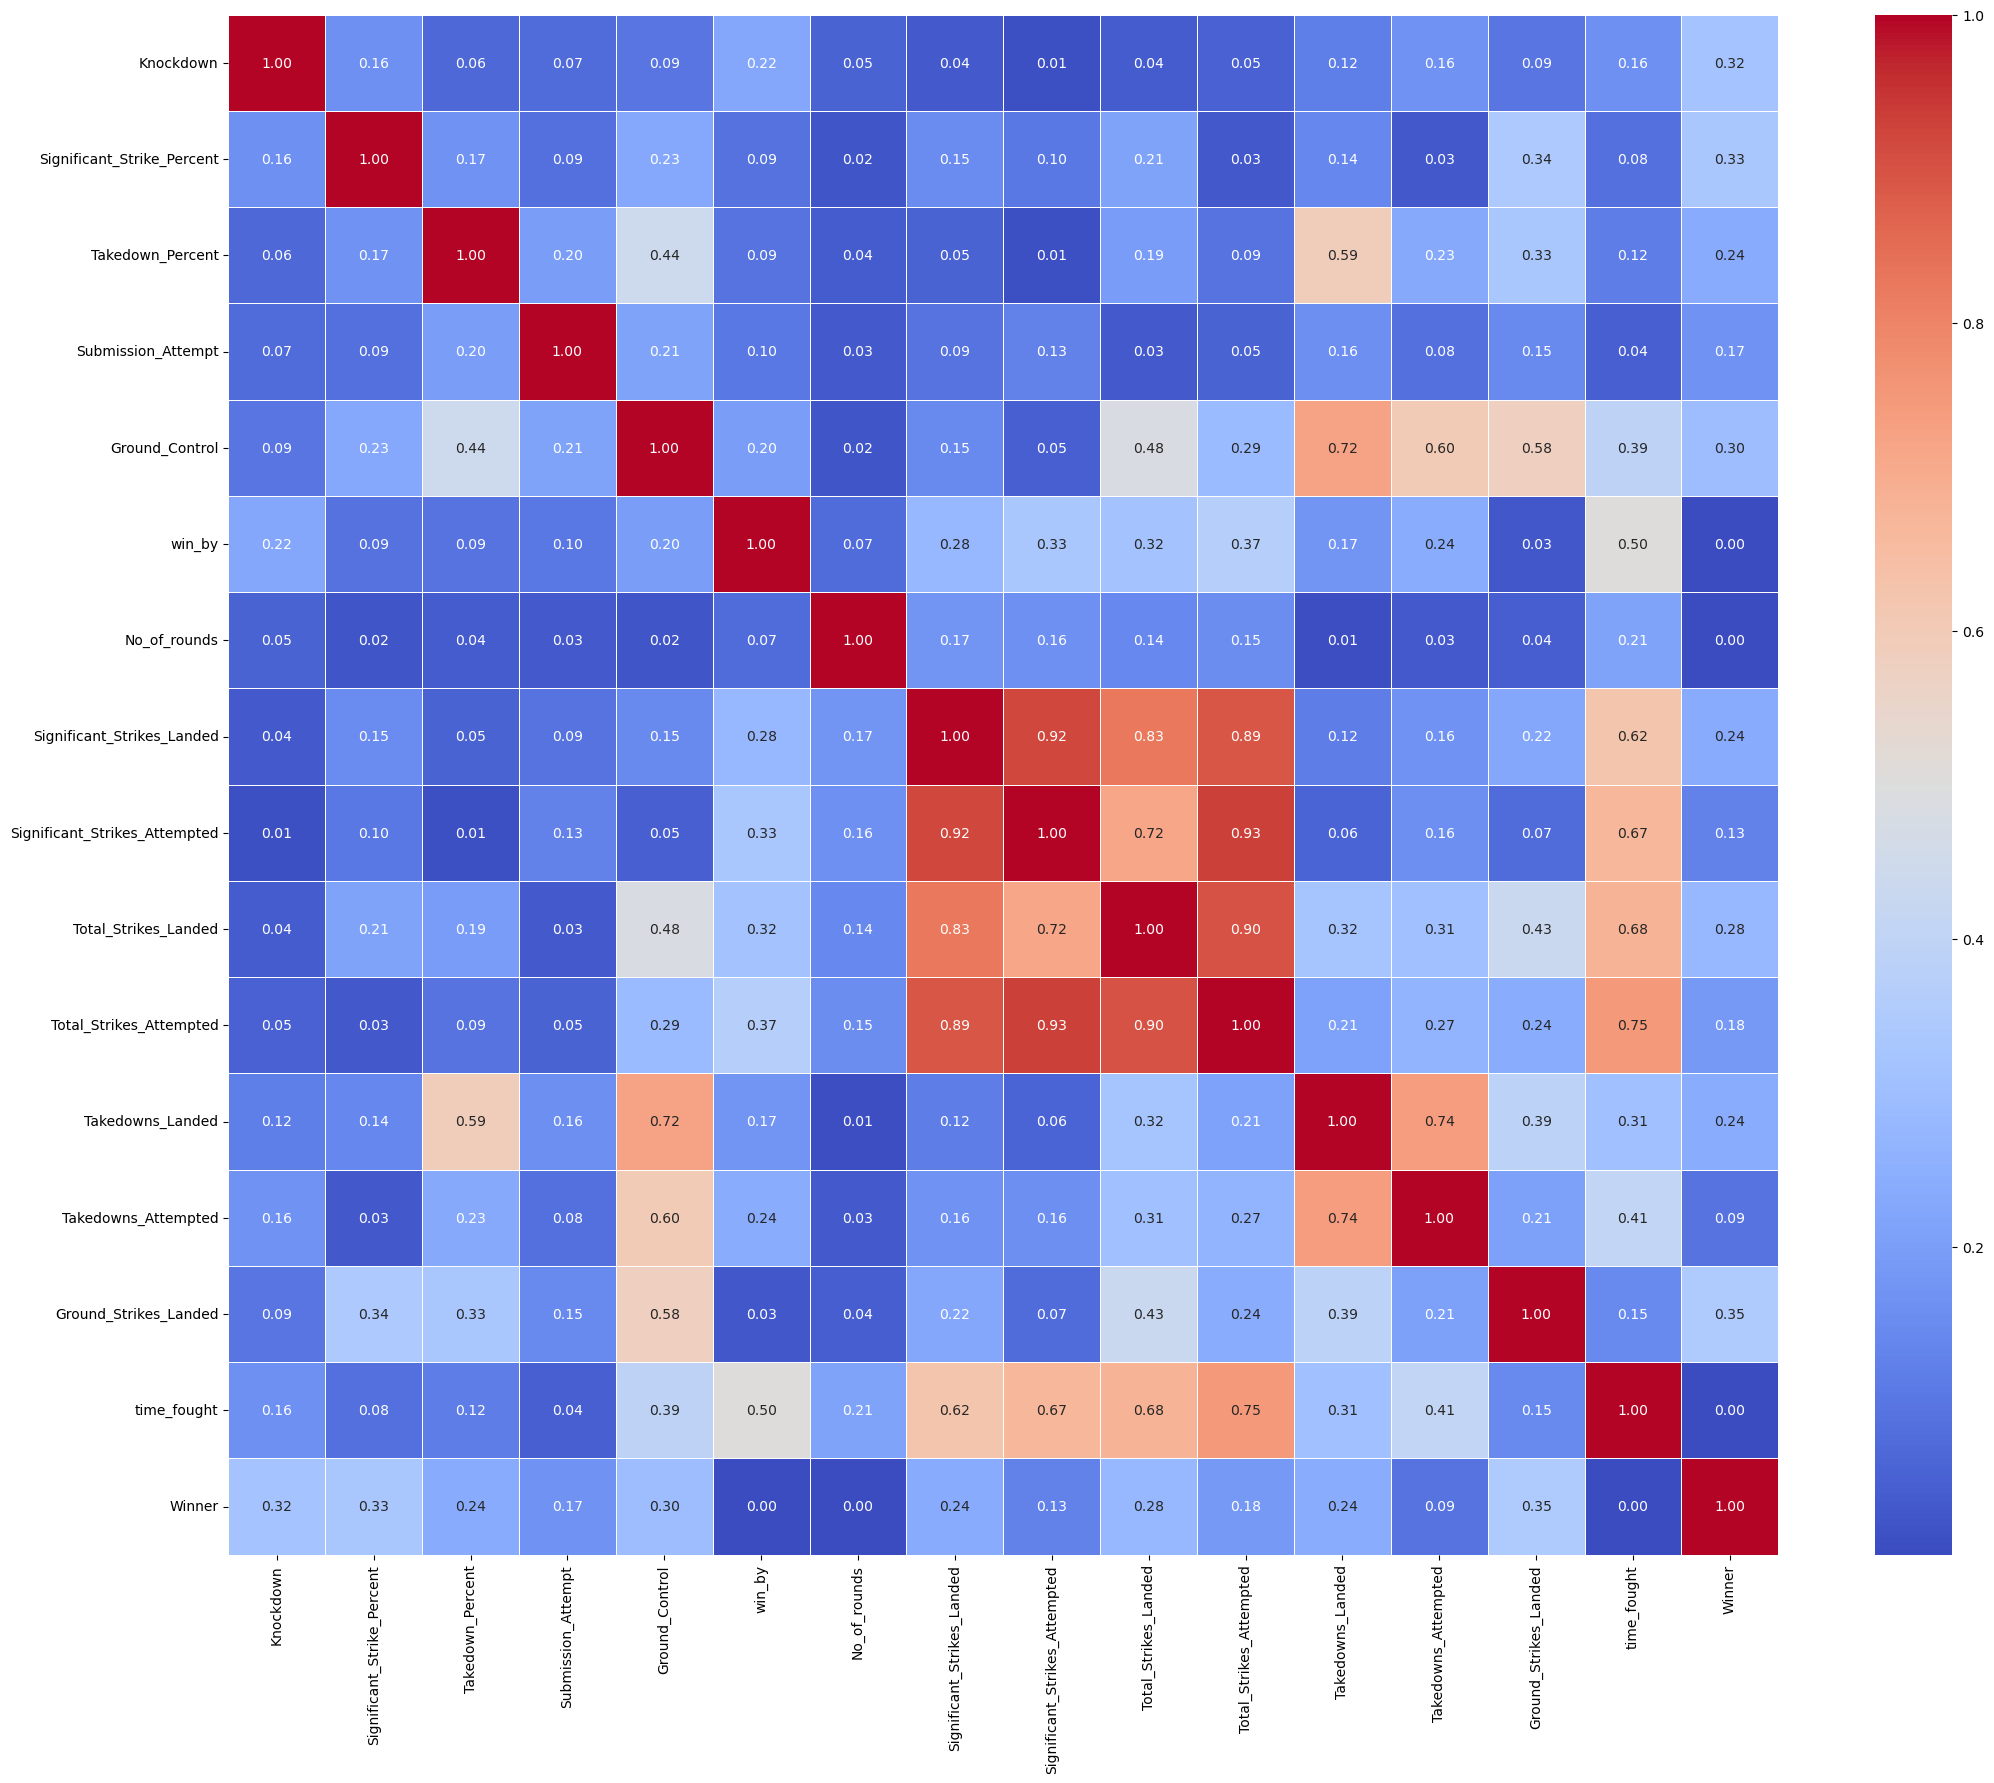

In [427]:
plt.figure(figsize=(25, 20))
corr_matrix = ufc.corr(method='pearson', numeric_only=True).abs()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)


In [428]:
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1)
                 .astype(bool))  # Use `bool` instead of `np.bool`
                 .stack()
                 .sort_values(ascending=False))

# Print the top 10 highest correlations
print(sol[0:10])

Significant_Strikes_Attempted  Total_Strikes_Attempted          0.931156
Significant_Strikes_Landed     Significant_Strikes_Attempted    0.920198
Total_Strikes_Landed           Total_Strikes_Attempted          0.899394
Significant_Strikes_Landed     Total_Strikes_Attempted          0.890770
                               Total_Strikes_Landed             0.825171
Total_Strikes_Attempted        time_fought                      0.748150
Takedowns_Landed               Takedowns_Attempted              0.740770
Ground_Control                 Takedowns_Landed                 0.724405
Significant_Strikes_Attempted  Total_Strikes_Landed             0.717295
Total_Strikes_Landed           time_fought                      0.681066
dtype: float64


In [429]:
ufc.isna().sum()

fighter                          0
Knockdown                        0
Significant_Strike_Percent       0
Takedown_Percent                 0
Submission_Attempt               0
Ground_Control                   0
win_by                           0
No_of_rounds                     0
date                             0
Fight_type                       0
Significant_Strikes_Landed       0
Significant_Strikes_Attempted    0
Total_Strikes_Landed             0
Total_Strikes_Attempted          0
Takedowns_Landed                 0
Takedowns_Attempted              0
Ground_Strikes_Landed            0
time_fought                      0
Winner                           0
dtype: int64

Need to create a gender column, to separate women and men's weight divisions

create a new column 'gender' in dataframe, and If column 'Fight_type' is W Strawweight or W Flyweight or W Bantamweight or W Featherweight, put the value 0 else make it 1.

In [430]:
def assign_gender(row):
    women_weights = ['W Strawweight', 'W Flyweight', 'W Bantamweight', 'W Featherweight']
    if row['Fight_type'] in women_weights:
        return 0
    else:
        return 1

In [431]:
ufc.insert(len(ufc.columns) - 1, 'Gender', ufc.apply(assign_gender, axis=1))

Removing all catch weight fights, because of convenience.

In [432]:
ufc = ufc[ufc['Fight_type'] != 'Catch Weight']

Changing weight division from names to numbers, so the model can process it.

In [433]:
mapping = {
    'W Strawweight': 115,
    'W Flyweight': 125,
    'W Bantamweight': 135,
    'W Featherweight': 145,
    'Flyweight': 125,
    'Bantamweight': 135,
    'Featherweight': 145,
    'Lightweight': 155,
    'Welterweight': 170,
    'Middleweight': 185,
    'Light Heavyweight': 205,
    'Heavyweight': 265,
}
pd.set_option('future.no_silent_downcasting', True)
ufc['Fight_type'] = ufc['Fight_type'].replace(mapping)

In [434]:
ufc.rename(columns={'Fight_type': 'Weight Division'}, inplace=True)

In [435]:
ufc.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,date,Weight Division,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Gender,Winner
0,Michelle Waterson-Gomez,0,32,50,0,61,7,3,2023-04-08,115,61,188,70,199,1,2,0,900,0,0
1,Gilbert Burns,0,42,66,0,341,9,3,2023-04-08,170,42,99,72,135,4,6,5,900,1,1
2,Steve Garcia,1,42,0,0,15,10,3,2023-04-08,145,17,40,50,77,0,0,4,336,1,1
3,Sam Hughes,0,44,100,0,422,9,3,2023-04-08,115,46,104,107,176,1,1,21,900,0,1
4,Loopy Godinez,0,48,0,0,1,7,3,2023-04-08,115,87,180,93,188,0,2,0,900,0,1


In [436]:
ufc.describe()

,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Gender,Winner
count,13206.000000,13206.000000,13206.000000,13206.000000,13206.000000,13206.000000,13206.000000,13206.000000,13206.000000,13206.000000,13206.00000,13206.000000,13206.000000,13206.000000,13206.000000,13206.000000,13206.000000
mean,0.220051,44.991670,26.633046,0.395729,134.657580,9.117068,3.177495,36.260412,82.393533,54.252840,102.82667,1.077465,2.863093,5.000076,637.487354,0.902317,0.499924
std,0.499794,16.627384,35.235814,0.845771,174.649872,0.842321,0.568780,31.525557,69.738276,43.656784,77.69168,1.701231,3.754613,8.964362,360.104337,0.296897,0.500019
min,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,3.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000
25%,0.000000,35.000000,0.000000,0.000000,6.000000,9.000000,3.000000,12.000000,28.000000,20.000000,38.00000,0.000000,0.000000,0.000000,283.000000,1.000000,0.000000
50%,0.000000,45.000000,0.000000,0.000000,61.000000,9.000000,3.000000,28.500000,66.000000,46.000000,91.00000,0.000000,1.000000,1.000000,837.000000,1.000000,0.000000
75%,0.000000,55.000000,50.000000,0.000000,199.000000,10.000000,3.000000,51.000000,118.000000,78.000000,150.00000,2.000000,4.000000,6.000000,900.000000,1.000000,1.000000
max,5.000000,100.000000,100.000000,10.000000,1342.000000,10.000000,5.000000,445.000000,744.000000,447.000000,746.00000,21.000000,49.000000,100.000000,1500.000000,1.000000,1.000000


In [437]:
date_column = ufc['date']  # Extract the 'date' column
ufc.drop(columns=['date'], inplace=True)  # Remove the 'date' column from its current position
ufc.insert(0, 'date', date_column)  # Insert the 'date' column at the first position


In [438]:
ufc2= ufc.copy()

# **Standardization**

In [439]:
print(ufc2.columns[2:-1].tolist())

['Knockdown', 'Significant_Strike_Percent', 'Takedown_Percent', 'Submission_Attempt', 'Ground_Control', 'win_by', 'No_of_rounds', 'Weight Division', 'Significant_Strikes_Landed', 'Significant_Strikes_Attempted', 'Total_Strikes_Landed', 'Total_Strikes_Attempted', 'Takedowns_Landed', 'Takedowns_Attempted', 'Ground_Strikes_Landed', 'time_fought', 'Gender']


In [440]:
columns_to_standardize = ufc2.columns[2:-1].tolist()

scaler = StandardScaler()
scaler.fit(ufc2[columns_to_standardize])

ufc2[columns_to_standardize] = scaler.transform(ufc2[columns_to_standardize])

In [441]:
ufc2.head()

,date,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,Weight Division,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Gender,Winner
0,2023-04-08,Michelle Waterson-Gomez,-0.440301,-0.781371,0.663184,-0.467909,-0.421760,-2.513469,-0.312075,-1.423125,0.784777,1.514383,0.360717,1.237931,-0.045536,-0.229884,-0.557794,0.729018,-3.039278,0
1,2023-04-08,Gilbert Burns,-0.440301,-0.179931,1.117285,-0.467909,1.181508,-0.138988,-0.312075,0.024069,0.182068,0.238135,0.406531,0.414131,1.717959,0.835512,-0.000008,0.729018,0.329026,1
2,2023-04-08,Steve Garcia,1.560599,-0.179931,-0.755880,-0.467909,-0.685154,1.048253,-0.312075,-0.633747,-0.610969,-0.607918,-0.097419,-0.332438,-0.633368,-0.762582,-0.111566,-0.837254,0.329026,1
3,2023-04-08,Sam Hughes,-0.440301,-0.059643,2.082249,-0.467909,1.645311,-0.138988,-0.312075,-1.423125,0.308954,0.309834,1.208269,0.941878,-0.045536,-0.496233,1.784904,0.729018,-3.039278,1
4,2023-04-08,Loopy Godinez,-0.440301,0.180933,-0.755880,-0.467909,-0.765318,-2.513469,-0.312075,-1.423125,1.609536,1.399664,0.887574,1.096341,-0.633368,-0.229884,-0.557794,0.729018,-3.039278,1


# **Train Test Split**

In [442]:
X = ufc2.iloc[:, 2:-1].values
y = ufc2.iloc[:, -1].values

In [443]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# **Logistic Regression Model**

In [444]:
from sklearn.linear_model import LogisticRegression
lr_classifier = LogisticRegression(random_state = 0)
lr_classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [445]:
y_pred = lr_classifier.predict(X_test)
print(y_pred)

[1 0 0 ... 0 1 1]


In [446]:
new_y_pred = y_pred.reshape(len(y_pred),1)
new_y_test = y_test.reshape(len(y_test),1)
np.concatenate((new_y_pred,new_y_test),1)

array([[1, 1],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [1, 1],
       [1, 1]])

In [447]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy_score(y_test, y_pred)
cm1 = confusion_matrix(y_pred, y_test)
print(cm1)
print(accuracy_score(y_test, y_pred))

[[1072  346]
 [ 209 1015]]
0.7899318697956094


# **Random Forest Model**

In [448]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 0)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=50, random_state=0)

In [449]:
y_pred = rf_classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 1]
 [0 0]
 [0 0]
 ...
 [0 0]
 [1 1]
 [1 1]]


In [450]:
cm2 = confusion_matrix(y_test, y_pred)
print(cm2)
accuracy_score(y_test, y_pred)

[[1072  209]
 [ 267 1094]]


0.8198334595003784

# **Decision Tree Model**

In [451]:
from sklearn.tree import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(criterion = 'gini', random_state = 0)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [452]:
y_pred = dt_classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 1]
 [0 0]
 [0 0]
 ...
 [0 0]
 [1 1]
 [1 1]]


In [453]:
cm3 = confusion_matrix(y_test, y_pred)
print(cm3)
accuracy_score(y_test, y_pred)

[[1008  273]
 [ 333 1028]]


0.7706283118849356

# **Naive Bayes Model**

In [454]:
from sklearn.naive_bayes import GaussianNB
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

GaussianNB()

In [455]:
y_pred = nb_classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 1]
 [0 0]
 [0 0]
 ...
 [0 0]
 [1 1]
 [1 1]]


In [456]:
cm4 = confusion_matrix(y_test, y_pred)
print(cm4)
accuracy_score(y_test, y_pred)

[[1075  206]
 [ 456  905]]


0.7494322482967449

# **KNN Model**

In [457]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

# n_neighbours = number of neighbours, metric = & = =2 to take euclidean distance
# euclidean distance is basically the geometric distance between 2 points
# p =1 = some other method under minkowski

knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [458]:
y_pred = knn_classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 1]
 [0 0]
 [0 0]
 ...
 [1 0]
 [1 1]
 [1 1]]


In [459]:
cm5 = confusion_matrix(y_test, y_pred)
print(cm5)
accuracy_score(y_test, y_pred)

[[1025  256]
 [ 292 1069]]


0.7925813777441333

# **SVM Model**

In [460]:
from sklearn.svm import SVC
svm_classifier = SVC(kernel = 'linear', random_state = 0)
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=0)

In [461]:
y_pred = svm_classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 1]
 [0 0]
 [0 0]
 ...
 [0 0]
 [1 1]
 [1 1]]


In [462]:
cm6 = confusion_matrix(y_test, y_pred)
print(cm6)
accuracy_score(y_test, y_pred)

[[1069  212]
 [ 339 1022]]


0.791445874337623

# **Prediction System**

In [463]:
ufc3 = ufc2.copy()

In [464]:
to_drop = ['Winner']


In [465]:
ufc3 = ufc3.drop(to_drop, axis=1)

In [466]:
ufc3.head()

,date,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,Weight Division,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Gender
0,2023-04-08,Michelle Waterson-Gomez,-0.440301,-0.781371,0.663184,-0.467909,-0.421760,-2.513469,-0.312075,-1.423125,0.784777,1.514383,0.360717,1.237931,-0.045536,-0.229884,-0.557794,0.729018,-3.039278
1,2023-04-08,Gilbert Burns,-0.440301,-0.179931,1.117285,-0.467909,1.181508,-0.138988,-0.312075,0.024069,0.182068,0.238135,0.406531,0.414131,1.717959,0.835512,-0.000008,0.729018,0.329026
2,2023-04-08,Steve Garcia,1.560599,-0.179931,-0.755880,-0.467909,-0.685154,1.048253,-0.312075,-0.633747,-0.610969,-0.607918,-0.097419,-0.332438,-0.633368,-0.762582,-0.111566,-0.837254,0.329026
3,2023-04-08,Sam Hughes,-0.440301,-0.059643,2.082249,-0.467909,1.645311,-0.138988,-0.312075,-1.423125,0.308954,0.309834,1.208269,0.941878,-0.045536,-0.496233,1.784904,0.729018,-3.039278
4,2023-04-08,Loopy Godinez,-0.440301,0.180933,-0.755880,-0.467909,-0.765318,-2.513469,-0.312075,-1.423125,1.609536,1.399664,0.887574,1.096341,-0.633368,-0.229884,-0.557794,0.729018,-3.039278


**Approach and Assumptions**

Now, to make a prediction IRL, I will only have 'names' of the fighters', but our model requires all other attributes as well. So what I am doing is, taking the mean value of all other attributes from a fighter's last 3 fights, as I feel like it's a good reflection of how the fighter is doing at any given point. If the fighter does not have 3 fights already in the UFC, I'll take mean of 2 fights, and if even that is not there then I will go with the values of just there first fight. 

In [467]:
ufc3.columns.tolist()

['date',
 'fighter',
 'Knockdown',
 'Significant_Strike_Percent',
 'Takedown_Percent',
 'Submission_Attempt',
 'Ground_Control',
 'win_by',
 'No_of_rounds',
 'Weight Division',
 'Significant_Strikes_Landed',
 'Significant_Strikes_Attempted',
 'Total_Strikes_Landed',
 'Total_Strikes_Attempted',
 'Takedowns_Landed',
 'Takedowns_Attempted',
 'Ground_Strikes_Landed',
 'time_fought',
 'Gender']

In [468]:
def calculate_avg_attributes(dataframe, years):
    df_temp = dataframe.sort_values('date', ascending=False)  # Sort by date in descending order

    grouped_df = df_temp.groupby('fighter').head(years)  # Select up to 'years' number of rows for each fighter

    exclude_columns = ['Weight Division', 'Gender']
    avg_attributes = grouped_df.groupby('fighter').apply(lambda x: x.mean(numeric_only=True) if len(x) > 0 else pd.Series())
    
    # Update 'Weight Division' and 'Gender' columns with the last (latest) value
    last_values = grouped_df.groupby('fighter')[exclude_columns].last()
    avg_attributes[exclude_columns] = last_values
    
    avg_attributes = avg_attributes.reset_index()
    return avg_attributes


In [469]:
avg_attributes_df = calculate_avg_attributes(ufc3, 3)

C:\Users\benso\AppData\Local\Temp\ipykernel_22032\346538165.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_attributes = grouped_df.groupby('fighter').apply(lambda x: x.mean(numeric_only=True) if len(x) > 0 else pd.Series())


In [470]:
avg_attributes_df.head()

,fighter,Knockdown,Significant_Strike_Percent,Takedown_Percent,Submission_Attempt,Ground_Control,win_by,No_of_rounds,Weight Division,Significant_Strikes_Landed,Significant_Strikes_Attempted,Total_Strikes_Landed,Total_Strikes_Attempted,Takedowns_Landed,Takedowns_Attempted,Ground_Strikes_Landed,time_fought,Gender
0,Alatengheili,0.226666,-0.159883,-0.074729,-0.467909,-0.061025,-0.534735,-0.312075,-0.896873,-0.177442,-0.048663,-0.143233,0.006522,0.738239,1.013079,-0.409051,-0.060598,0.329026
1,Aoriqileng,0.226666,0.401461,0.899695,-0.467909,-0.358775,0.256759,-0.312075,-1.159999,1.228878,0.988588,0.864667,0.894681,0.150408,-0.052318,0.371848,0.051411,0.329026
2,Maheshate,3.561499,1.504102,-0.755880,-0.467909,-0.771044,1.048253,-0.312075,-0.370620,-0.928184,-1.038114,-1.082412,-1.194854,-0.633368,-0.762582,-0.557794,-1.564848,0.329026
3,Sumudaerji,0.226666,0.261125,0.190163,-0.467909,-0.351140,0.256759,-0.312075,-0.896873,0.456988,0.262034,-0.005792,0.019394,-0.437424,-0.673799,0.409034,-0.063375,0.329026
4,Wulijiburen,-0.440301,-0.240075,0.464515,0.123290,0.491530,-0.138988,-0.312075,-0.633747,-0.610969,-0.529048,-0.544102,-0.544824,1.424043,1.501385,-0.278901,0.729018,0.329026


In [471]:
def get_fighter_row(dataframe, fighter_name):
    row = dataframe.loc[dataframe['fighter'] == fighter_name]
    row_values = row.values.flatten()[1:]  # Exclude the 'fighter' column
    return row_values

Since **Random Forest** had the best results, I am taking it to make calculate the probability of a fighter winning their next fight.

In [472]:
def get_win_probability(fighter_name):
    fighter_name = fighter_name
    fighter_row = get_fighter_row(avg_attributes_df, fighter_name)
    win_prob = rf_classifier.predict_proba([fighter_row])[0][1]
    return win_prob

**Add name of a fighter to get the probability of them winning their next fight.**


In [473]:
get_win_probability('Stipe Miocic')

0.82

In [474]:
def match_probability(fighter_A, fighter_B):
    fighter_A = fighter_A
    fighter_B = fighter_B
    prob_A = get_win_probability(fighter_A)
    prob_B = get_win_probability(fighter_B)
    total_prob = prob_A + prob_B
    probability_A = round(prob_A / total_prob, 2)
    probability_B = round(prob_B / total_prob, 2)
    return probability_A, probability_B


Add 2 names here.

In [475]:
match_probability('Conor McGregor', 'Michael Chandler')

(0.55, 0.45)